<a href="https://colab.research.google.com/github/antoreep-jana/YouTube_Code_Repositories/blob/main/Weekly%20Sessions/Weekly_Session__13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Implementing MobileNet

In [ ]:
import tensorflow as tf

In [ ]:
class MobileNetBlock(tf.keras.Model):
  
  def __init__(self, filters, strides):
    super(MobileNetBlock, self).__init__()
    self.depthwise = tf.keras.layers.DepthwiseConv2D((3,3), strides = strides, padding = 'same')
    self.bn1 = tf.keras.layers.BatchNormalization()
    self.bn2 = tf.keras.layers.BatchNormalization()
    self.relu = tf.keras.layers.ReLU()
    self.conv = tf.keras.layers.Conv2D(filters =  filters, kernel_size = (1,1), strides = 1)


  def call(self, x):
    x = self.depthwise(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv(x)
    x = self.bn2(x)
    x = self.relu(x)

    return x


class MobileNet(tf.keras.Model):

  def __init__(self):
    super(MobileNet, self).__init__()
    self.conv = tf.keras.layers.Conv2D(32, (3,3), 2, padding ='same')
    self.avgPool = tf.keras.layers.AveragePooling2D((7,7), strides = 1)
    self.dense = tf.keras.layers.Dense(1000, activation = 'softmax')
    self.relu = tf.keras.layers.ReLU()
    self.bn = tf.keras.layers.BatchNormalization()

  def call(self, x):
    x = self.conv(x)
    x = self.bn(x)
    x = self.relu(x)

    x = MobileNetBlock(64, 1)(x)
    x = MobileNetBlock(128, 2)(x)
    x = MobileNetBlock(128, 1)(x)
    x = MobileNetBlock(256, 2)(x)
    x = MobileNetBlock(256, 1)(x)
    x = MobileNetBlock(512, 2)(x)

    for _ in range(5):
      x = MobileNetBlock(512, 1)(x)

    x = MobileNetBlock(1024, 2)(x)
    x = MobileNetBlock(1024, 1)(x)

    x = self.avgPool(x)
    x = self.dense(x)

    return x
    
    
    
    
    
    
    

In [ ]:
model = MobileNet()

model.build((None, 224,224,3))

model.summary()

Model: "mobile_net_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            multiple                  896       
_________________________________________________________________
average_pooling2d_3 (Average multiple                  0         
_________________________________________________________________
dense_5 (Dense)              multiple                  1025000   
_________________________________________________________________
re_lu_10 (ReLU)              multiple                  0         
_________________________________________________________________
batch_normalization_3 (Batch multiple                  128       
Total params: 1,026,024
Trainable params: 1,025,960
Non-trainable params: 64
_________________________________________________________________


Implementing XCeption

In [ ]:
import tensorflow as tf

In [ ]:
class Conv_BN(tf.keras.Model):

  def __init__(self, filters, kernel_size, strides = 1):
    
    super(Conv_BN, self).__init__()
    self.conv = tf.keras.layers.Conv2D(filters = filters, kernel_size =kernel_size, strides = strides, padding = 'same', use_bias = False)
    self.bn = tf.keras.layers.BatchNormalization()

  def call(self, x):
    x = self.conv(x)
    x = self.bn(x)
    return x


class Sep_BN(tf.keras.Model):
  
  def __init__(self, filters, kernel_size, strides = 1):
    super(Sep_BN, self).__init__()
    self.sep = tf.keras.layers.SeparableConv2D(filters = filters, kernel_size = kernel_size, strides = strides, padding = 'same', use_bias = False)
    self.bn = tf.keras.layers.BatchNormalization()

  def call(self, x):
    x = self.sep(x)
    x = self.bn(x)

    return x

In [ ]:
class EntryFlow(tf.keras.Model):
  def __init__(self):
    super(EntryFlow, self).__init__()

    self.relu = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool2D((3,3), (2,2), padding = 'same')

    self.add = tf.keras.layers.Add()

    

  def call(self, x):
    
    x = Conv_BN(32, (3,3), (2,2))(x)
    x = self.relu(x)

    x = Conv_BN(64, (3,3))(x)
    x = self.relu(x)

    path1 = Conv_BN( 128 , (1,1), (2,2))(x)

    path2 = Sep_BN(128, (3,3))(x)
    path2 = self.relu(path2)
    path2 = Sep_BN(128, (3,3))(path2)
    path2 = self.maxpool(path2)

    x = self.add([path1, path2])


    path1 = Conv_BN(256, (1,1), (2,2))(x)

    path2 = self.relu(x)
    path2 = Sep_BN(256, (3,3))(path2)
    path2 = self.relu(path2)
    path2 = Sep_BN(256, (3,3))(path2)
    path2 = self.maxpool(path2)

    x = self.add([path1, path2])

    path1 = Conv_BN(728, (1,1), (2,2))(x)

    path2 = self.relu(x)
    path2 = Sep_BN(728, (3,3))(path2)
    path2 = self.relu(path2)
    path2 = Sep_BN(728, (3,3))(path2)
    path2 = self.maxpool(path2)

    return self.add([path1, path2])




class MiddleFlow(tf.keras.Model):
  def __init__(self):
    super(MiddleFlow, self).__init__()
    self.relu = tf.keras.layers.ReLU()
    self.add = tf.keras.layers.Add()

  def call(self, x):
    

    for _ in range(8):

      path1 = x

      path2 = self.relu(x)
      path2 = Sep_BN(728, (3,3))(path2)
      path2 = self.relu(path2)
      path2 = Sep_BN(728, (3,3))(path2)
      path2 = self.relu(path2)
      path2 = Sep_BN(728, (3,3))(path2)

      x = self.add([path1, path2])

    return x

class ExitFlow(tf.keras.Model):
  def __init__(self):
    super(ExitFlow, self).__init__()
    
    self.relu = tf.keras.layers.ReLU()
    self.maxpool = tf.keras.layers.MaxPool2D((3,3), (2,2), padding = 'same')
    self.globalAvgPool = tf.keras.layers.GlobalAveragePooling2D()
    self.dense = tf.keras.layers.Dense(1000, activation = 'softmax')
    self.add = tf.keras.layers.Add()

  def call(self, x):
    

    path1 = Conv_BN(1024, (1, 1), (2,2))(x)

    path2 = self.relu(x)
    path2 = Sep_BN(728, (3,3))(path2)
    path2 = self.relu(path2)
    path2 = Sep_BN(1024, (3,3))(path2)
    path2 = self.maxpool(path2)

    x = self.add([path1, path2])

    x = Sep_BN(1536, (3,3))(x)
    x = self.relu(x)
    x = Sep_BN(2048, (3,3))(x)
    x = self.relu(x)

    x = self.globalAvgPool(x)
    x = self.dense(x)

    return x

In [ ]:
class XceptionNet(tf.keras.Model):
  
  def __init__(self):

    super(XceptionNet, self).__init__()
    self.entryFlow = EntryFlow()
    self.middleFlow = MiddleFlow()
    self.exitFlow = ExitFlow()

  def call(self, x):

    x = self.entryFlow(x)
    x = self.middleFlow(x)
    x = self.exitFlow(x)

    return x
    


model = XceptionNet()
model.build((None, 299,299,3))

Understanding EfficientNet Architecture

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras.utils import plot_model

In [ ]:
model1 = tf.keras.applications.EfficientNetB0()

model1.summary()

21848064/21834768 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
____________________

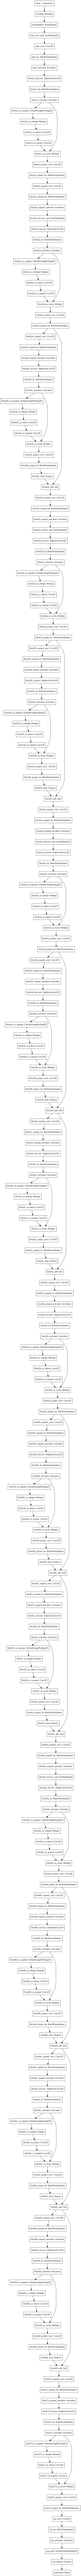

In [ ]:
plot_model(model1)